## Problem 3: Multiple Regression

Extend your simple Bayesian regression model from the previous exercise into a multiple regression model:

\begin{aligned}
\sigma &\sim \text{Inv-Gamma}(\tau_0, \tau_1) \\
\alpha &\sim \text{Normal}(0, \sigma_\alpha) \\
\beta &\sim \text{Multivariate-Normal}(0, \sigma_\beta \mathbb{I}) \\
y_n &\sim \text{Normal}(\alpha + \beta x_n^T, \sigma) \quad \text{for } n = 1, \dots, N,
\end{aligned}

where you need to set the hyperparameters of the prior (i.e., $\tau_0, \tau_1, \sigma_\beta, \sigma_\alpha$) to some reasonable values. Next, use your **Stan** program to fit a Bayesian multiple regression model for the Insurance Costs data set: **data/insurance.csv**

Your goal is to predict the insurance charges (**charges**) from a patient’s BMI (**bmi**), age (**age**), and number of children (**children**). Thus, you need to estimate three regression weights ($\beta_1, \beta_2, \beta_3$), along with the intercept ($\alpha$), and the noise parameter ($\sigma$). It is also recommended that you standardize your predictors (i.e., subtract the means from the input variables and divide by their standard deviations) in order to bring them to a common scale.

Split the data into a training set and a test set and fit the model only to the training set. Perform the usual convergence checks and describe your results. **Which of the three variables is the best predictor of Insurance Charges?**

In [110]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import stan

import arviz as az

import nest_asyncio
nest_asyncio.apply()

### Load and Preprocess Data

In [111]:
# Load dataset
df = pd.read_csv("data/insurance.csv")

# Select predictors and target
X_raw = df[['bmi', 'age', 'children']]
y_raw = df['charges']

# Split into training and test sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

# Standardize predictors
scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# Normalize target
y_mean, y_std = y_train_raw.mean(), y_train_raw.std()
y_train = (y_train_raw - y_mean) / y_std

### Stan Code

In [112]:
program_code = """
data {
  int<lower=1> N;            
  int<lower=1> K;            
  matrix[N, K] X;           
  vector[N] y;  

  // for Problem 4
  int<lower=1> M;            
  matrix[M, K] X_test;       
            
}
parameters {
  real alpha;                
  vector[K] beta;            
  real<lower=0> sigma;       
}
model {
  // Priors
  sigma ~ inv_gamma(2, 1);
  alpha ~ normal(0, 10);
  beta ~ normal(0, 1);

  // Likelihood
  y ~ normal(alpha + X * beta, sigma);
}
generated quantities {
  vector[M] y_rep;           
  for (m in 1:M) {
    y_rep[m] = normal_rng(alpha + X_test[m] * beta, sigma);
  }
}
"""

### Model Fitting

In [ ]:
# Prepare data
stan_dict = {
    'N': len(y_train),
    'K': X_train.shape[1],
    'X': X_train.tolist(),
    'y': y_train.tolist(), 
    'M':    X_test.shape[0],
    'X_test': X_test.tolist()
}

# Compile the model
posterior = stan.build(program_code, data=stan_dict, random_seed=42)

# Sample from the posterior
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   3% (400/14000)
Sampling:   6% (800/14000)
Sampling:   9% (1200/14000)
Sampling:  11% (1500/14000)
Sampling:  13% (1800/14000)
Sampling:  14% (2000/14000)
Sampling:  16% (2300/14000)
Sampling:  38% (5300/14000)
Sampling:  51% (7100/14000)
Sampling:  71% (10000/14000)
Sampling:  91% (12800/14000)
Sampling:  93% (13000/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000258 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.58 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000444 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.44 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive!

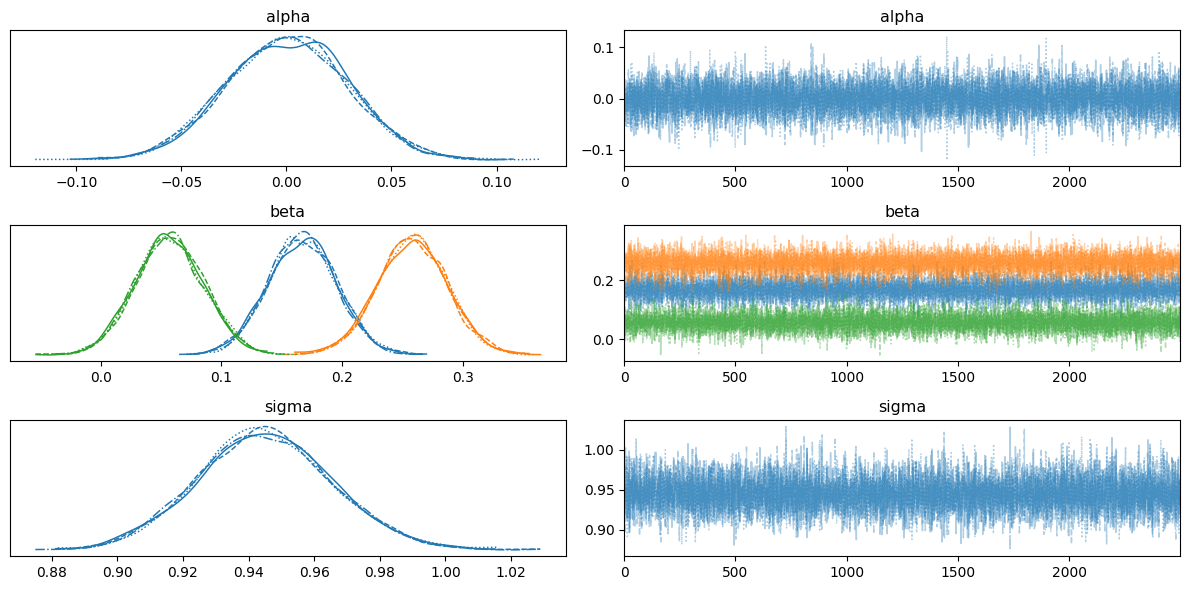

In [114]:
_ = az.plot_trace(fit, var_names=['alpha', 'beta', 'sigma'])
plt.tight_layout()

For all of the variables, traceplots show good convergence and mixing. 

In [115]:
az.summary(fit, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.029,-0.053,0.054,0.0,0.0,12066.0,7895.0,1.0
beta[0],0.167,0.029,0.114,0.220,0.0,0.0,13535.0,7954.0,1.0
beta[1],0.258,0.029,0.203,0.312,0.0,0.0,12148.0,7088.0,1.0
beta[2],0.057,0.028,0.003,0.109,0.0,0.0,11829.0,7564.0,1.0
sigma,0.945,0.020,0.908,0.985,0.0,0.0,13155.0,7535.0,1.0


Based on the summary, we can see that the model converged and the estimates are reliable (i.e. r_hat are 1.0, bulk and tail ess are all high, and mcse are all 0.0). 

Since beta[1] has the largest coefficient (0.258), **Age** is the best predictor of insurance charges in this data set. 


### Use the Bayesian Ridge regression

In [116]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

In [117]:
# Fit Bayesian Ridge Regression
model = BayesianRidge()
model.fit(X_train, y_train)

# Print Coefficients
print("Intercept:", model.intercept_)
print("Coefficients:")
for name, coef in zip(['bmi', 'age', 'children'], model.coef_):
    print(f"  {name}: {coef:.4f}")

Intercept: 1.32198841171523e-16
Coefficients:
  bmi: 0.1634
  age: 0.2523
  children: 0.0558


As we can see, **Age**'s coefficient is the largest, which matches with result from our Stan model.  

In [118]:
# Evaluate on Test Set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Set MSE: {mse:.2f}")
print(f"Test Set R² Score: {r2:.2f}")


Test Set MSE: 0.90
Test Set R² Score: 0.15


Bayesian Ridge Regression in scikit-learn is a faster, simpler method that uses an approximate approach to estimate the model. It assumes fixed, standard priors and finds the best parameters by maximizing likelihood, rather than sampling.

In contrast, the custom Bayesian model uses full sampling to estimate the entire range of possible parameter values. This gives more flexibility and a deeper understanding of uncertainty, but it takes longer to run and is more complex to set up.

As a result, while the custom model offers more precise and comprehensive uncertainty quantification and modeling flexibility, the Bayesian Ridge implementation in scikit-learn is faster and easier to use for standard regression problems.

## Problem 4: Predictive Distribution

Use the **generated quantities** block in the **Stan** program to also pass the test data and sample from the predictive distribution (or do so using Bayesian ridge). Extract the samples from the predictive distribution, compute the means predictive means from the samples, calculate the root-mean-squared error (RMSE) between the predictive means and the actual charges in the test set:

$$\text{RMSE} = \sqrt{\frac{1}{M} \sum_{m=1}^{M} (\hat{y}_m - y_m)^2},$$

where $M$ denotes the number of test instances and $\hat{y}_m$ denotes the predictive means.

How good are your predictions? What information did you lose by computing the predictive means? How could you possibly propagate the uncertainty information encoded in the predictive distribution to obtain a distribution over the test RMSE values?

Added the generated quantities block in the Stan program

In [126]:
y_test_preds = fit['y_rep']            # shape (268, 10000)
pred_means_std = y_test_preds.mean(axis=1)
pred_means     = pred_means_std * y_std + y_mean

y_true = y_test_raw.values
rmse = np.sqrt(np.mean((pred_means - y_true)**2))
print(f"Test RMSE = {rmse:.2f} dollars")

Test RMSE = 11448.94 dollars


In [ ]:
# First, ensure y_test_preds is shape (n_draws, M):
M = X_test.shape[0]
if y_test_preds.shape[0] == M:
    y_test_preds = y_test_preds.T 

# Compute RMSE for each draw
rmse_draws = np.sqrt(np.mean((y_test_preds - y_true[None, :])**2, axis=1))

# Now you have a full posterior over RMSE:
print("Mean RMSE:",     rmse_draws.mean())
print("95% CI RMSE:",   np.quantile(rmse_draws, [0.025, 0.975]))


Mean RMSE: 17983.958240501986
95% CI RMSE: [17983.83671586 17984.08026076]
